* Author: Meng-Xuan
* Modified by Hsuan-Pei

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

In [2]:
behavior_files = Path("../data/20230831/behavior_raw_data").glob("*.csv")
output_dir = Path("../data/20230831/behavior_selected_data/")
os.makedirs(output_dir, exist_ok=True)

all_raw_df = []

for filepath in behavior_files:
    df = pd.read_csv(filepath)
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    all_raw_df.append(df)

In [3]:
target_duration = 300  # s

In [4]:
_df = all_raw_df[0]

# XXX
for i in range(1, len(_df)-1):
    if tuple(_df["SLAP2_acquiring"][i-1:i+1+1]) == (1, 0, 1):
        all_raw_df[0].loc[i, 'SLAP2_acquiring'] = 1

# consecutive ones
slap2_recordings = ((_df["SLAP2_acquiring"].shift() - _df["SLAP2_acquiring"]) == -1).cumsum()
slap2_recordings[_df["SLAP2_acquiring"] == 0] = 0

grouped = _df[_df["SLAP2_acquiring"] != 0].groupby(slap2_recordings)

output_idx = 1
for name, group in grouped:
    duration = np.ptp(group["Time"]) / 1000
    if (target_duration - 1) <= duration <= (target_duration + 1):
        group["Time"] -= group["Time"].iloc[0]
        group.to_csv(output_dir/f"{filepath.stem}_{target_duration}_{output_idx}.csv", index=False)
        output_idx += 1

---

In [5]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time (s)')

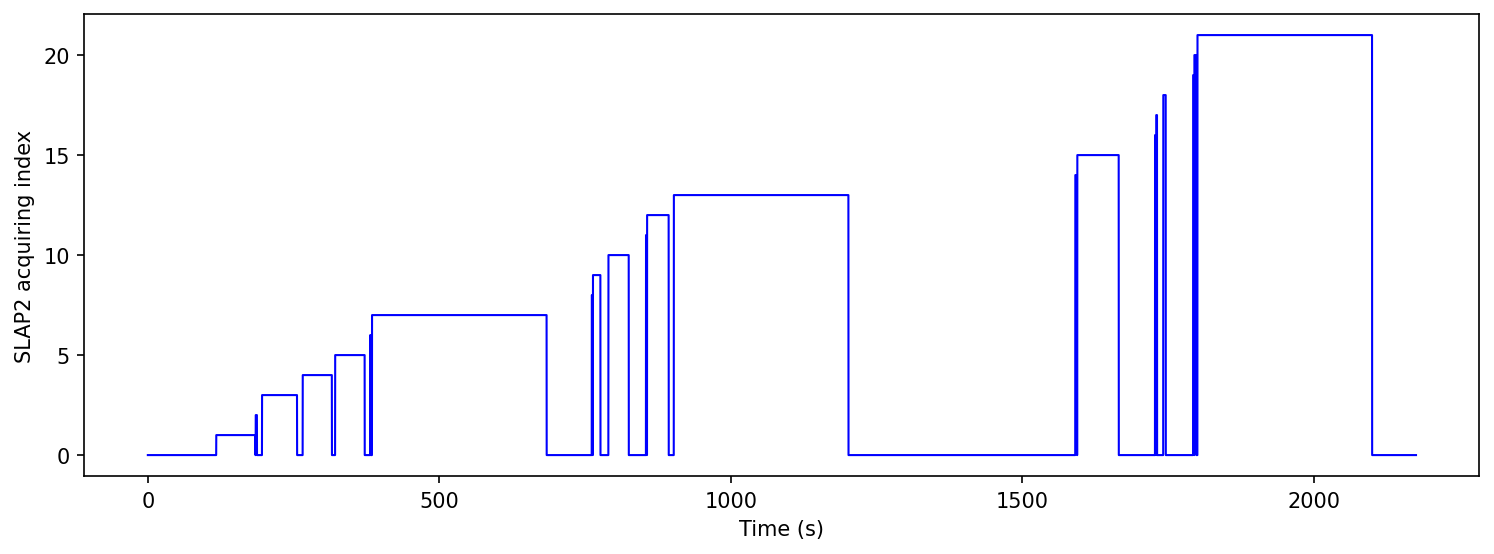

In [6]:
plt.figure(figsize=(12,  4), dpi=150)
# slap2_recordings[slap2_recordings != 0] = 1
plt.plot(_df["Time"] / 1000, slap2_recordings, lw=1, color="b")
plt.ylabel("SLAP2 acquiring index")
plt.xlabel("Time (s)")